In [1]:
import warnings
warnings.simplefilter('ignore')

# Dependencies
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

In [2]:
df = pd.read_csv('data/sarima_monthly.csv', index_col=0)
df.tail()

,nb_cases,nb_units
month,,
2019-01-01,193559,312134
2019-02-01,179632,292222
2019-03-01,198692,324640
2019-04-01,206121,332745
2019-05-01,28172,45003


In [3]:
df.at['2019-05-01', 'nb_cases'] = 194501 # average of first 4 months in 2019
df.at['2019-05-01', 'nb_units'] = 315435 # average of first 4 months in 2019
df.tail()


,nb_cases,nb_units
month,,
2019-01-01,193559,312134
2019-02-01,179632,292222
2019-03-01,198692,324640
2019-04-01,206121,332745
2019-05-01,194501,315435


In [4]:
df.reset_index(inplace=True)
df.head()

,month,nb_cases,nb_units
0,2011-07-01,128,150
1,2011-08-01,108,138
2,2011-09-01,89,103
3,2011-10-01,69,85
4,2011-11-01,71,98


In [5]:
df.month = pd.to_datetime(df.month)
df.set_index(['month'], inplace=True)
df.index.name=None
df.head()

,nb_cases,nb_units
2011-07-01,128,150
2011-08-01,108,138
2011-09-01,89,103
2011-10-01,69,85
2011-11-01,71,98


# STEP 1: Visualize the data

We first want to visualize the data to understand what type of model we should use. Is there an overall trend in the data? Does the data show any seasonal trends? This is important when deciding which type of model to use. If there isn’t a seasonal trend in the data, then we can just use a regular ARIMA model instead. If we are using daily data for our time series and there is too much variation in the data to determine the trends, we might want to resample our data by month, or look at the rolling mean.

As we visualize our data, we can see there is an upward trend in the data and there appears to be some seasonality to it, especially if we look at the data from 2017 onward:

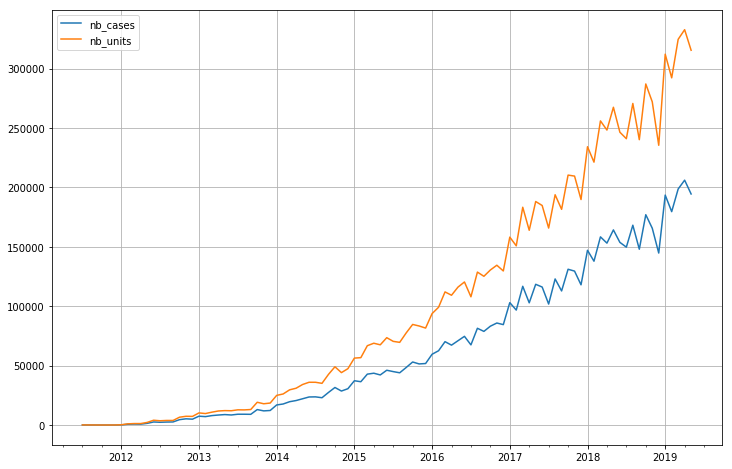

In [9]:
df.plot(grid=True)
plt.show()

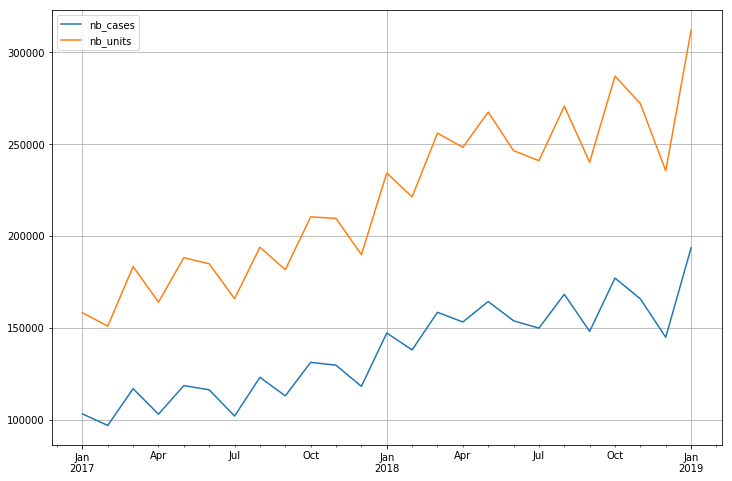

In [10]:
start_date = datetime(2017, 1, 1)
end_date = datetime(2019, 1, 1)
df_17on = df[(start_date <= df.index) & (df.index <= end_date)]
df_17on.plot(grid=True)

Another tool to visualize the data is the seasonal_decompose function in statsmodel. With this, the trend and seasonality become even more obvious.

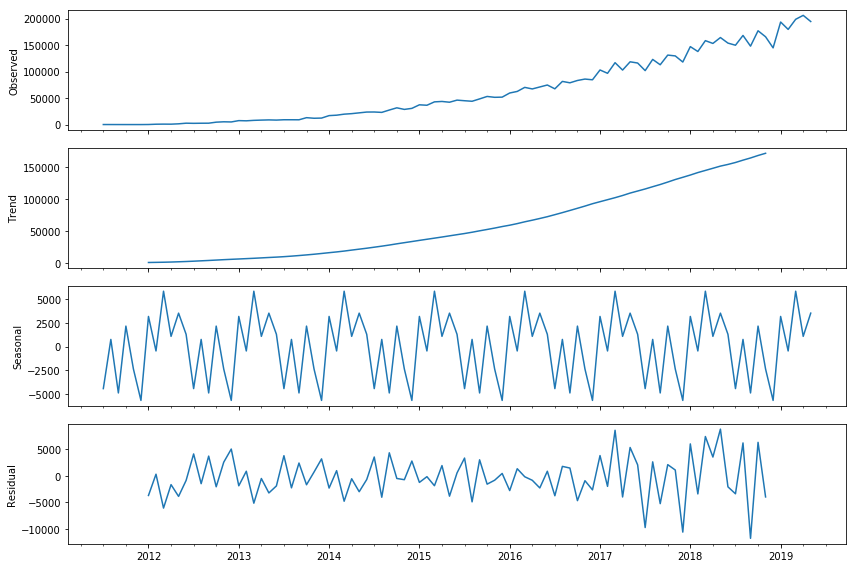

In [11]:
decomposition_cases = sm.tsa.seasonal_decompose(df['nb_cases'], model = 'additive')
fig_cases = decomposition_cases.plot()

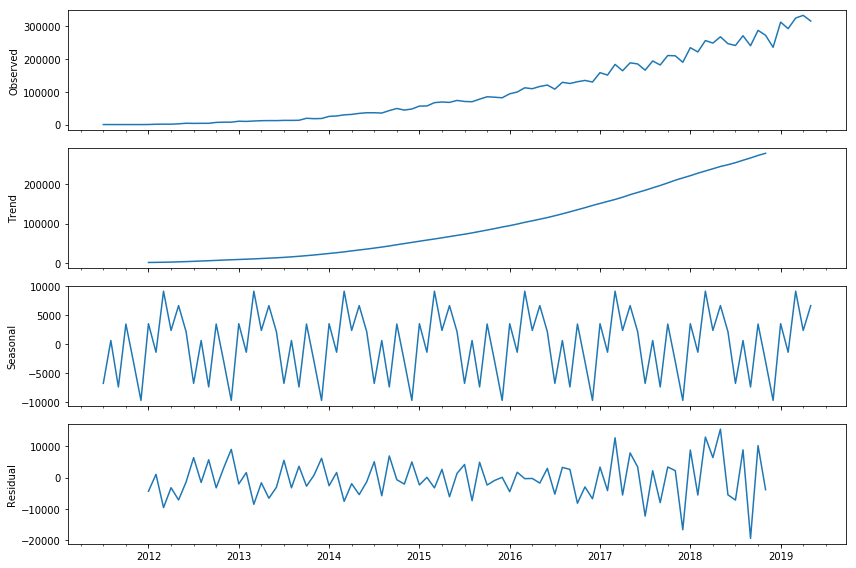

In [12]:
decomposition_units = sm.tsa.seasonal_decompose(df['nb_units'], model = 'additive')
fig_units = decomposition_units.plot()

The residual values essentially take out the trend and seasonality of the data, making the values independent of time. One could try to model the residuals using exogenous variables, but it could be tricky to then try and convert the predicted residual values back into meaningful numbers.

# STEP 2: Stationarize the data

Data is considered stationary when the mean of the series, the variance of the series (homoscedasticity), and  covariance of the i th term and the (i + m) th term are not a function of time.

Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

There are two ways we can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test. 

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

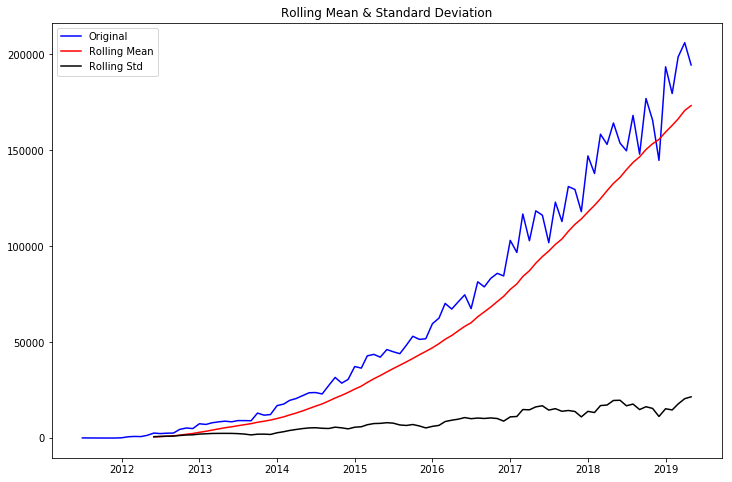

Results of Dickey-Fuller Test:
Test Statistic                  1.861464
p-value                         0.998463
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [14]:
test_stationarity(df.nb_cases)

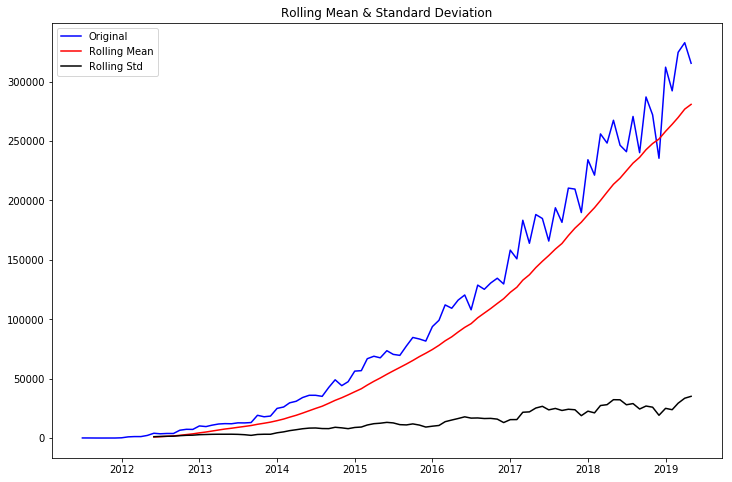

Results of Dickey-Fuller Test:
Test Statistic                  1.072616
p-value                         0.994976
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [15]:
test_stationarity(df.nb_units)

We can easily see that the time series are not stationary, and our test_stationarity function confirms what we see.

So now we need to transform the data to make it more stationary. There are various transformations we can do to stationarize the data.

- Deflation by CPI
- Logarithmic
- First Difference
- Seasonal Difference
- Seasonal Adjustment

Taking the log values improves the results:

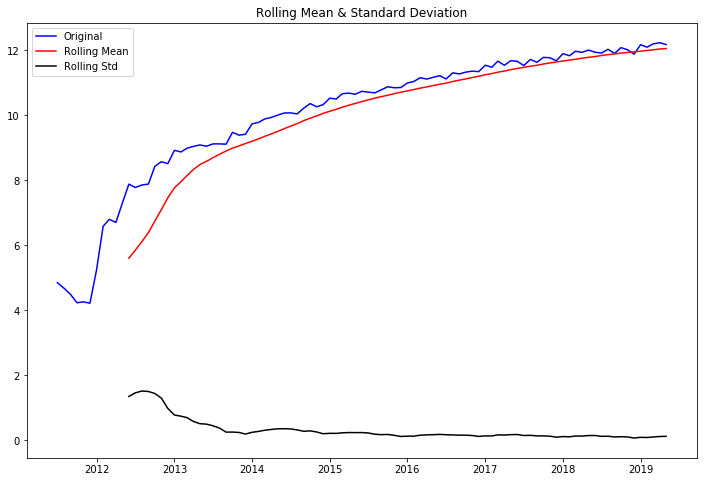

Results of Dickey-Fuller Test:
Test Statistic                 -1.548333
p-value                         0.509481
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [16]:
df.cases_log= df.nb_cases.apply(lambda x: np.log(x))  
test_stationarity(df.cases_log)

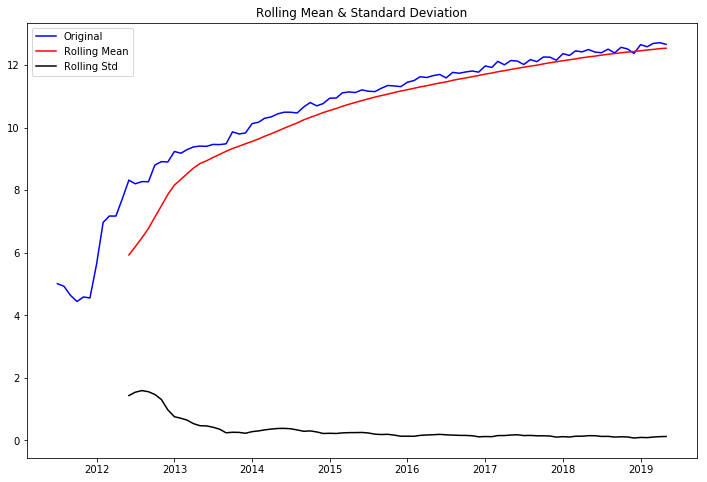

Results of Dickey-Fuller Test:
Test Statistic                 -1.758267
p-value                         0.401369
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [17]:
df.units_log= df.nb_units.apply(lambda x: np.log(x))  
test_stationarity(df.units_log)

Taking the first difference:

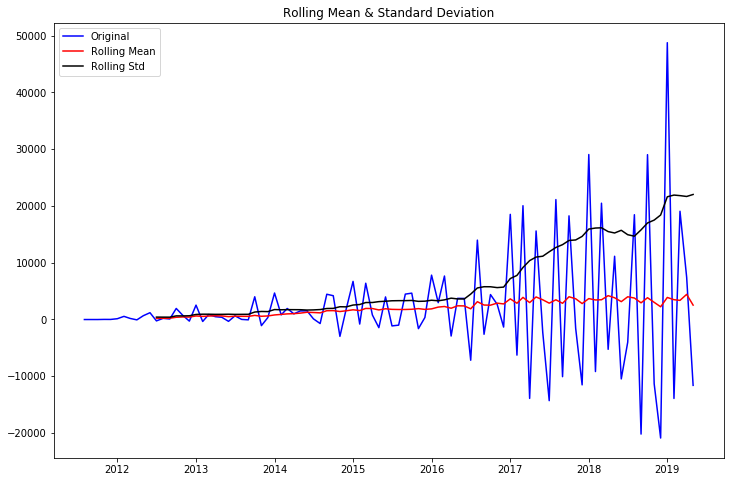

Results of Dickey-Fuller Test:
Test Statistic                 -1.125843
p-value                         0.704657
#Lags Used                     12.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [18]:
df['first_difference_cases'] = df.nb_cases - df.nb_cases.shift(1)  
test_stationarity(df.first_difference_cases.dropna(inplace=False))

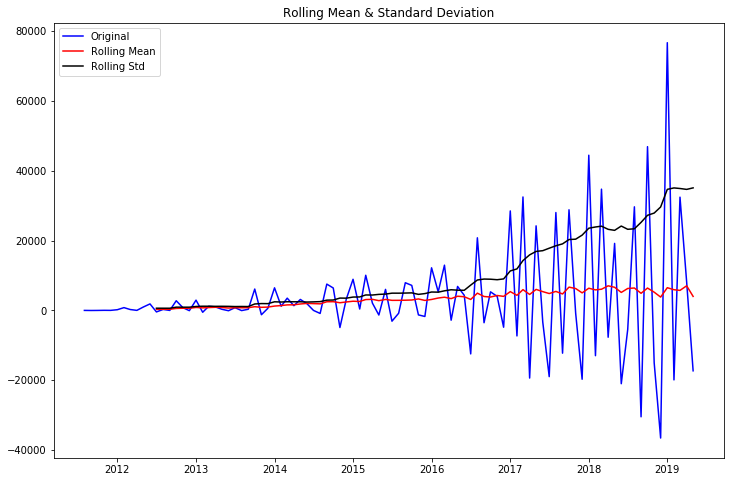

Results of Dickey-Fuller Test:
Test Statistic                 -1.154304
p-value                         0.692938
#Lags Used                     12.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [19]:
df['first_difference_units'] = df.nb_units - df.nb_units.shift(1)  
test_stationarity(df.first_difference_units.dropna(inplace=False))

Taking the first difference improved things a lot less than taking the log. Let's look at the log first difference:

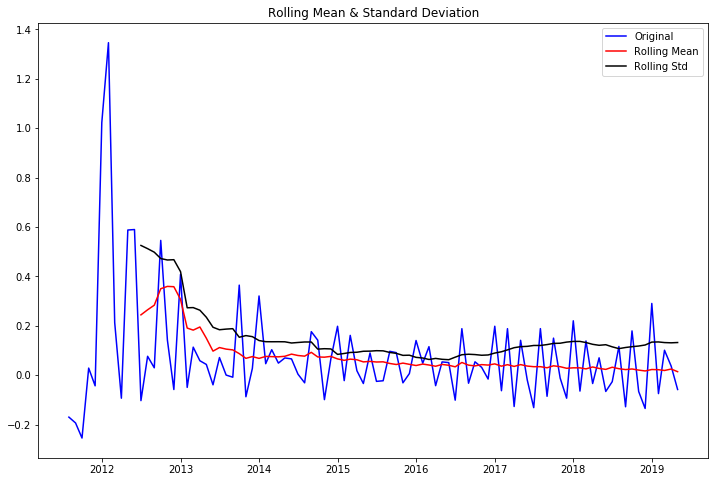

Results of Dickey-Fuller Test:
Test Statistic                 -4.174951
p-value                         0.000726
#Lags Used                     12.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [20]:
df['log_first_difference_cases'] = df.cases_log - df.cases_log.shift(1)  
test_stationarity(df.log_first_difference_cases.dropna(inplace=False))

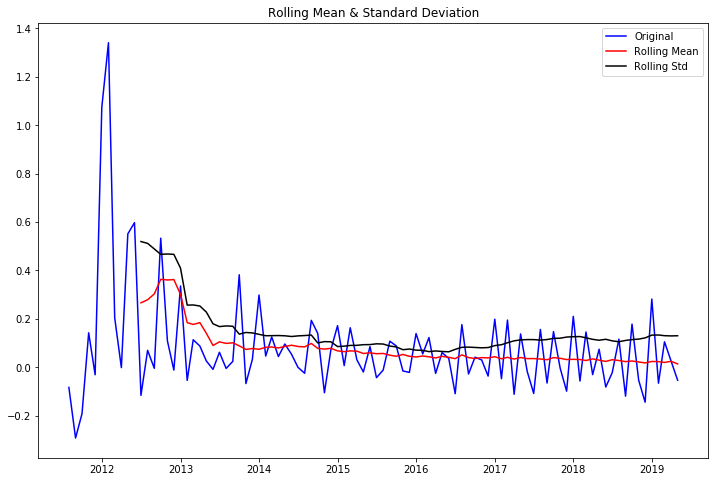

Results of Dickey-Fuller Test:
Test Statistic                 -3.822136
p-value                         0.002689
#Lags Used                     12.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [21]:
df['log_first_difference_units'] = df.units_log - df.units_log.shift(1)
test_stationarity(df.log_first_difference_units.dropna(inplace=False))

As we can see by the p-value, taking the log first difference has now made our data stationary.

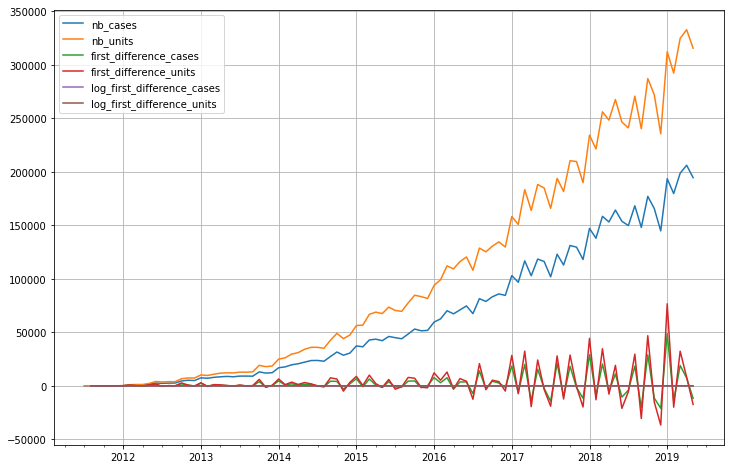

In [22]:
df.plot(grid=True)
plt.show()

It looks like there is some seasonality:

# STEP 3: Plot the ACF and PACF charts and find the optimal parameters

The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. There are many rules and best practices about how to select the appropriate AR, MA, SAR, and MAR terms for the model. The big issue as with all models is to be careful not to overfit our model to the data by using too many terms.

Below are the ACF and PACF charts for the log first difference values:

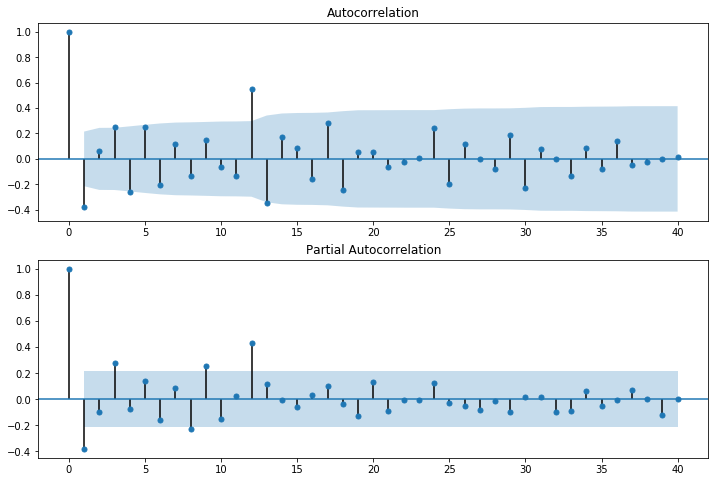

In [23]:
fig_cases = plt.figure(figsize=(12,8))
ax1_cases = fig_cases.add_subplot(211)
fig_cases = sm.graphics.tsa.plot_acf(df.log_first_difference_cases.iloc[12:], lags=40, ax=ax1_cases)
ax2_cases = fig_cases.add_subplot(212)
fig_cases = sm.graphics.tsa.plot_pacf(df.log_first_difference_cases.iloc[12:], lags=40, ax=ax2_cases)

### Optimal parameters for nb_cases series (with seasonal config):
See 'LabStar_Forecasting_Monthly' jupyter notebook for the code used.

The best result was an RMSE of about 11,284 cases with the following configuration:
- Trend Order: (0, 1, 1)
- Seasonal Order: (1, 0, 1, 12) at first, then (0, 0, 1, 12)
- Trend Parameter: ‘c’ (constant)

### Optimal parameters for nb_units series (with seasonal config):
See 'LabStar_Forecasting_Monthly' jupyter notebook for the code used.

The best result was an RMSE of about 18,986 units with the following configuration:
- Trend Order: (1, 0, 0)
- Seasonal Order: (1, 1, 1, 12) at first, then (0, 1, 1, 12)
- Trend Parameter: ‘ct’ (constant with linear trend) at first, then 'c'

# STEP 4: Build the Model

In [6]:
# For the number of cases:
model_cases = sm.tsa.statespace.SARIMAX(df.nb_cases, trend='c', order=(0,1,1), seasonal_order=(0,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
results_cases = model_cases.fit()
print(results_cases.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           nb_cases   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -823.089
Date:                            Fri, 31 May 2019   AIC                           1654.178
Time:                                    04:05:26   BIC                           1664.393
Sample:                                07-01-2011   HQIC                          1658.306
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5493.4953   1254.481      4.379      0.000    3034.757    7952.234
ma.L1         -0.4281      0.116   

In [9]:
# For the number of units:
model_units = sm.tsa.statespace.SARIMAX(df.nb_units, trend='c', order=(1,0,0), seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results_units = model_units.fit()
print(results_units.summary())


                                 Statespace Model Results                                 
Dep. Variable:                           nb_units   No. Observations:                   95
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 12)   Log Likelihood                -739.188
Date:                            Thu, 30 May 2019   AIC                           1486.376
Time:                                    22:48:53   BIC                           1496.591
Sample:                                07-01-2011   HQIC                          1490.504
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4563.9040   6747.944      0.676      0.499   -8661.823    1.78e+04
ar.L1          0.8864      0.110   

# STEP 5: Make Predictions

First we use the model to forecast for time periods that we already have data for, so we can understand how accurate  the forecasts are.

### Forecasting number of cases:

In [8]:
df

,nb_cases,nb_units
2011-07-01,128,150
2011-08-01,108,138
2011-09-01,89,103
2011-10-01,69,85
2011-11-01,71,98
2011-12-01,68,95
2012-01-01,189,278
2012-02-01,726,1063
2012-03-01,898,1304
2012-04-01,818,1302


In [11]:
df

,nb_cases,nb_units,forecast_cases
2011-07-01,128,150,NaN
2011-08-01,108,138,NaN
2011-09-01,89,103,NaN
2011-10-01,69,85,NaN
2011-11-01,71,98,NaN
2011-12-01,68,95,NaN
2012-01-01,189,278,NaN
2012-02-01,726,1063,NaN
2012-03-01,898,1304,NaN
2012-04-01,818,1302,NaN


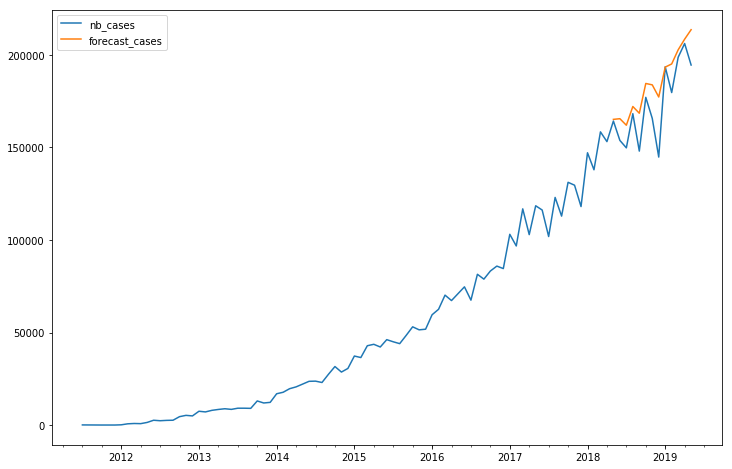

In [10]:
df['forecast_cases'] = results_cases.predict(start = 82, end= 94, dynamic= True)  
df[['nb_cases', 'forecast_cases']].plot(figsize=(12, 8))

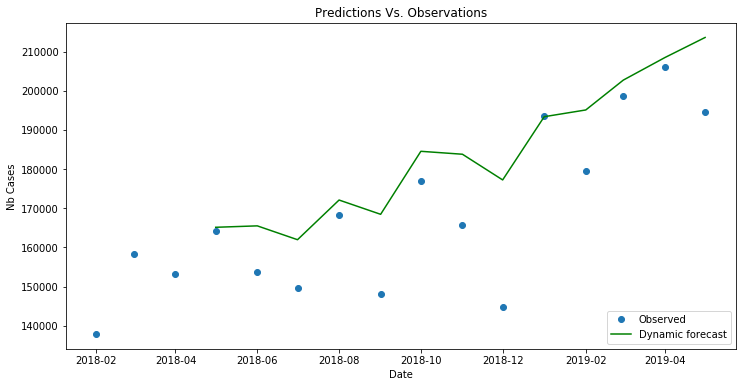

In [26]:
# Zooming in:
npredict =df.nb_cases['2019'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Predictions Vs. Observations', xlabel='Date', ylabel='Nb Cases')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'nb_cases'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast_cases'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

Then we generate future forecasts:

In [12]:
# Add new time periods to the dataframe
start = datetime.strptime("2019-06-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])

In [13]:
future

,nb_cases,nb_units,forecast_cases
2019-06-01,NaN,NaN,NaN
2019-07-01,NaN,NaN,NaN
2019-08-01,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN
2020-02-01,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN


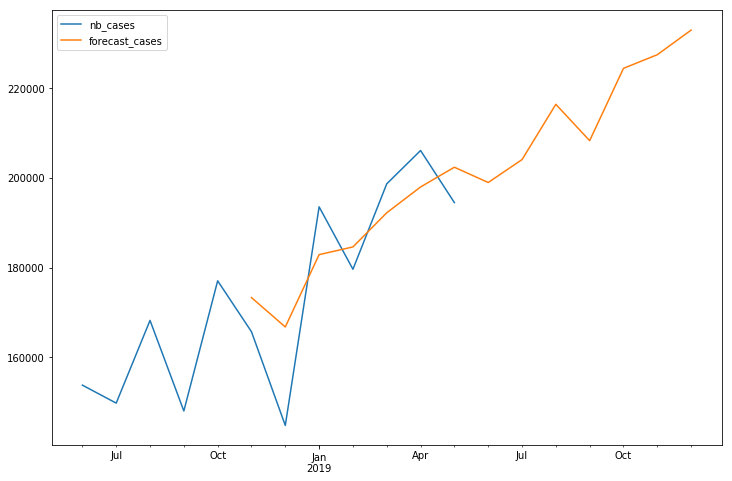

In [33]:
df['forecast_cases'] = results_cases.predict(start = 88, end = 101, dynamic= True)  
df[['nb_cases', 'forecast_cases']].ix[-24:].plot(figsize=(12, 8)) 

### Forecasting number of units:

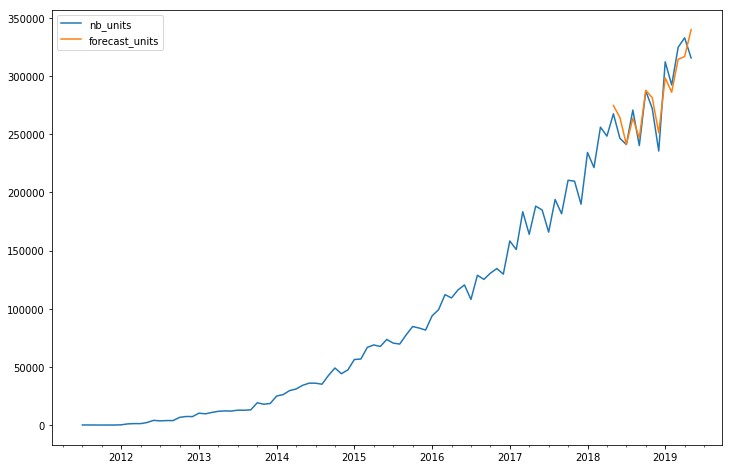

In [29]:
df['forecast_units'] = results_units.predict(start = 82, end= 94, dynamic= True)  
df[['nb_units', 'forecast_units']].plot(figsize=(12, 8))

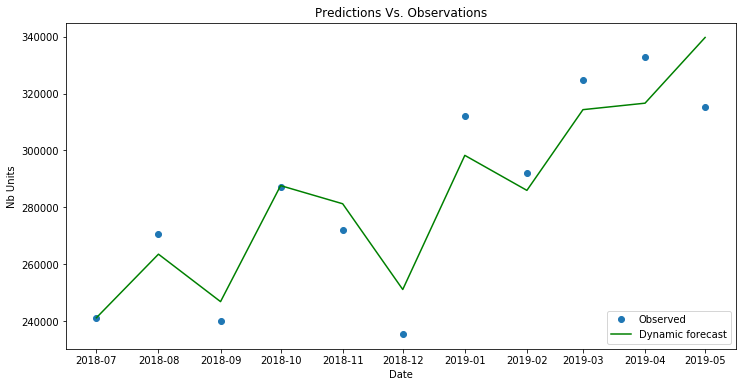

In [30]:
# Zooming in:
npredict = df.nb_units['2019'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Predictions Vs. Observations', xlabel='Date', ylabel='Nb Units')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'nb_units'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast_units'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

Then we generate future forecasts:

In [12]:
fm = 12 #got up to 12 only

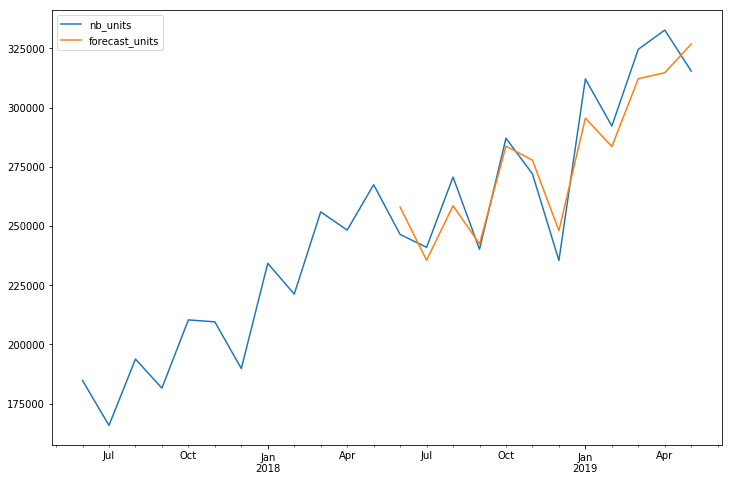

In [13]:
df['forecast_units'] = results_units.predict(start = 83, end = 94+int(fm), dynamic= True)  
df[['nb_units', 'forecast_units']].ix[-24:].plot(figsize=(12, 8)) 

In [34]:
df.ix[-24:]

,nb_cases,nb_units,forecast_cases,forecast_units
2018-06-01,153781,246463,165516.760026,257998.751414
2018-07-01,149771,241020,161985.480061,235578.264286
2018-08-01,168223,270672,172107.374890,258571.617013
2018-09-01,148016,240191,168464.528671,242449.566351
2018-10-01,177048,287070,184542.601326,283742.147676
2018-11-01,165696,272040,183793.265108,277803.896340
2018-12-01,144793,235478,177237.475567,248052.939420
2019-01-01,193559,312134,193372.582453,295561.742073
2019-02-01,179632,292222,195091.532659,283561.238614
2019-03-01,198692,324640,202712.043195,312216.172365


In [42]:
df

,nb_cases,nb_units,first_difference_cases,first_difference_units,log_first_difference_cases,log_first_difference_units,forecast_cases,forecast_units
2011-07-01,128,150,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,108,138,-20.0,-12.0,-0.169899,-0.083382,NaN,NaN
2011-09-01,89,103,-19.0,-35.0,-0.193495,-0.292525,NaN,NaN
2011-10-01,69,85,-20.0,-18.0,-0.254530,-0.192078,NaN,NaN
2011-11-01,71,98,2.0,13.0,0.028573,0.142316,NaN,NaN
2011-12-01,68,95,-3.0,-3.0,-0.043172,-0.031091,NaN,NaN
2012-01-01,189,278,121.0,183.0,1.022239,1.073744,NaN,NaN
2012-02-01,726,1063,537.0,785.0,1.345803,1.341229,NaN,NaN
2012-03-01,898,1304,172.0,241.0,0.212620,0.204341,NaN,NaN
2012-04-01,818,1302,-80.0,-2.0,-0.093308,-0.001535,NaN,NaN
